# Large Language Models 

In this lab, I explored the understanding capabilities of an LLM, specifically the [T5 model](https://arxiv.org/pdf/1910.10683). T5 is an encoder-decoder text-to-text Transformer that has been trained on a wide range of tasks including machine translation, summarization and sentiment analysis.

To start, I focused on the concept of text embeddings by extracting T5 embeddings and visualizing them for different words and sentences. This helped me get a better intuition for how the model represents semantic information.

Next, I used T5 for sentiment analysis, aiming to build a classifier that determines whether a movie review is positive or negative. For this I used the [IMDB dataset](https://huggingface.co/datasets/stanfordnlp/imdb) and experimented with several approaches:
- Building a classic machine learning classifier on top of T5 embeddings.
- Using the pretrained encoder-decoder T5 model directly for sentiment analysis.
- Fine-tuning T5 to improve classification performance.

## Installs and imports

In [1]:
!pip install datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from tqdm import tqdm #used to estimate how much time remains for certain loops

## Model

The model from the HuggingFace repository has two primary components that we need:

- **Tokenizer**: Responsible for converting text strings into integer tokens that the model can process.
- **Model**: Contains the pretrained weights and the architecture required

Note: I used a smaller model because I didn't want to run out of memory in my Colab session

In [ ]:
T5_MODEL = "google-t5/t5-small"
CUDA = True if torch.cuda.is_available() else False

tokenizer = T5Tokenizer.from_pretrained(T5_MODEL)
model = T5ForConditionalGeneration.from_pretrained(T5_MODEL)

if CUDA:
    model = model.cuda()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

## Tokenization and embeddings

Start with **tokenization**. It describes the process of dividing a text string into smaller sub-units, normally codified as integers for efficient processing. I use T5's tokenizer to illustrate this.

In [ ]:
def tokenize_text(text, tokenizer):

    tokenizer_out = tokenizer(text, padding=True)
    input_ids = torch.tensor(tokenizer_out["input_ids"])
    attention_mask = torch.tensor(tokenizer_out["attention_mask"])

    if CUDA:
        input_ids = input_ids.cuda()
        attention_mask = attention_mask.cuda()

    return input_ids, attention_mask

text_sentences = [
    "The cat sits on the mat.",
    "A cat is sitting on the rug.",
    "There is a cat lying on the carpet.",
    "The sky is blue.",
    "A blue sky.",
    "The skies are blue."
]
input_ids, attention_mask = tokenize_text(text_sentences, tokenizer)

print("Input text in string form:")
print(text_sentences)
print("\n")
print("Input text in tokenised form:")
print(input_ids)
for i in range(len(text_sentences)):
    print(tokenizer.convert_ids_to_tokens(input_ids[i]))
print("\n")
#Note: The attention mask is used to indicate which tokens should be attended to (1) and which should not (0, usually padding).
print("Attention mask:")
print(attention_mask)

Input text in string form:
['The cat sits on the mat.', 'A cat is sitting on the rug.', 'There is a cat lying on the carpet.', 'The sky is blue.', 'A blue sky.', 'The skies are blue.']


Input text in tokenised form:
tensor([[   37,  1712,  2561,     7,    30,     8,  6928,     5,     1,     0,
             0],
        [   71,  1712,    19,  3823,    30,     8,  9787,     5,     1,     0,
             0],
        [  290,    19,     3,     9,  1712, 12267,    30,     8,  4898,     5,
             1],
        [   37,  5796,    19,  1692,     5,     1,     0,     0,     0,     0,
             0],
        [   71,  1692,  5796,     5,     1,     0,     0,     0,     0,     0,
             0],
        [   37, 22902,    33,  1692,     5,     1,     0,     0,     0,     0,
             0]])
['▁The', '▁cat', '▁sit', 's', '▁on', '▁the', '▁mat', '.', '</s>', '<pad>', '<pad>']
['▁A', '▁cat', '▁is', '▁sitting', '▁on', '▁the', '▁rug', '.', '</s>', '<pad>', '<pad>']
['▁There', '▁is', '▁', 'a', '▁cat'

Turn the input ids and attention mask into a corresponding **text embeddings**. A text embedding is a dense numerical vector representation of text that captures its semantic meaning in a format suitable for machine learning models.

In [ ]:
def get_text_embeddings(text, tokenizer, model):
    with torch.no_grad():
      input_ids, attention_mask = tokenize_text(text, tokenizer)
      text_embeddings = model.encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
      return text_embeddings

text_embeddings = get_text_embeddings(text_sentences, tokenizer, model)

print(f"Text tokens shape = {input_ids.shape}")
print(f"Text embeddings shape = {text_embeddings.shape}")

Text tokens shape = torch.Size([6, 11])
Text embeddings shape = torch.Size([6, 11, 512])


### Example Visualization
We can now visualize how similar the sentences are in the embedding space. For this I use the following method: 
- 1) Compute the average of the sequence dimension in your embeddings. This means going from (batch_size, sequence_len, embed_dim) to (batch_size, embed_dim), by computing the mean over "sequence_len".
- 2) Use [sklearn's PCA](https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.PCA.html) (dimmensionality reduction technique) to get 2 main components from the 512-dim embedding.
- 3) Plot these 2 main components in a 2D plot.

Average text embedding shape = (6, 512)
2d version of embded average text = (6, 2)


Text(0, 0.5, 'PCA Dimension 2')

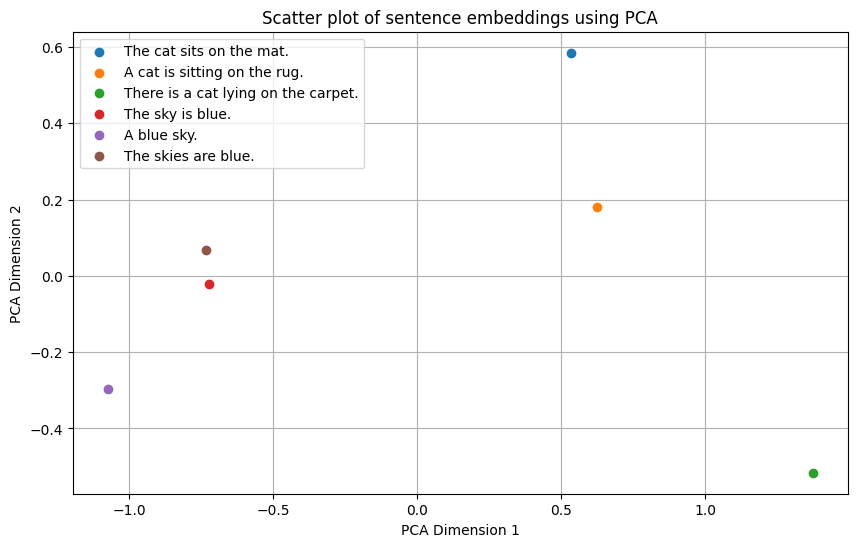

In [ ]:
#1.average out the sequence length dimension.
avg_text_embeddings = torch.mean(text_embeddings, dim=1).cpu().detach().numpy()
print(f"Average text embedding shape = {avg_text_embeddings.shape}")

#2.fit a PCA and transform "text_embeddings_avg" from 512-dim to 2-dim.
pca = PCA(n_components=2, svd_solver='full')
embedding_2d = pca.fit_transform(avg_text_embeddings)
print(f"2d version of embded average text = {embedding_2d.shape}")

#3.plot every sentence PCA embedding in a 2D plot.
plt.figure(figsize=(10, 6))
for i, embedding in enumerate(embedding_2d):
    plt.scatter(embedding[0], embedding[1], marker='o', label=text_sentences[i])
plt.legend(loc="best")
plt.grid()
plt.title("Scatter plot of sentence embeddings using PCA")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")

## The IMDB dataset

Download the IMDB dataset, which contains many user reviews of movies, and has manual labels about whether these reviews are positive or not. I tried to build multiple classifiers that perform such understanding task.


In [7]:
# Download IMDB dataset
imdb = load_dataset("imdb")
imdb

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

### Data Exploration

The dataset has three partitions: One for training, another for testing, and another for unsupervised learning, with no labels.

Lets view some of the reviews and label for data exploraion purposes.

In [ ]:
#Collect some positive and negative reviews.
N_REVIEWS = 20 # Number of reviews to collect for each class

positive_reviews = []
negative_reviews = []
for review in imdb["train"]:
    text, label = review["text"], review["label"]
    if label == 1 and len(positive_reviews) < N_REVIEWS:
        positive_reviews.append(text)
    elif label == 0 and len(negative_reviews) < N_REVIEWS:
        negative_reviews.append(text)

    if len(positive_reviews) == N_REVIEWS and len(negative_reviews) == N_REVIEWS:
        break

In [ ]:
#Print some positive reviews
VISUALIZE = 3
for index, positive_review in enumerate(positive_reviews):
    print(positive_review)
    if index == VISUALIZE - 1:
        break

Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn't really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I'd have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is presented as a dream/nightmare, and making it too coherent would spoil the effect. <br /><br />This movie is unrelentingly grim--"noir" in more than one sense; one never sees the sun shine. Grim, but intriguing, and frightening.
Zentropa is the most original movie I've seen in years. If you like unique thrillers that are influenced by film noir, then this is just the right cure for all of those Hollywood summer blockbusters clogging the theaters these days. Von Trier's follow-ups like Breaking t

In [ ]:
#Print some negative reviews
VISUALIZE = 3
for index, negative_review in enumerate(negative_reviews):
    print(negative_review)
    if index == VISUALIZE - 1:
        break

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, eve

### Example visualization of positive and negative sentiments

Visualize 20 positive and 20 negative reviews in the same way as described earlier to show their approximated proximities in the embedding space

Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors


Text embeddings shape = torch.Size([40, 1417, 512])
Average text embedding shape = (40, 512)
2d version of embedded average text = (40, 512)


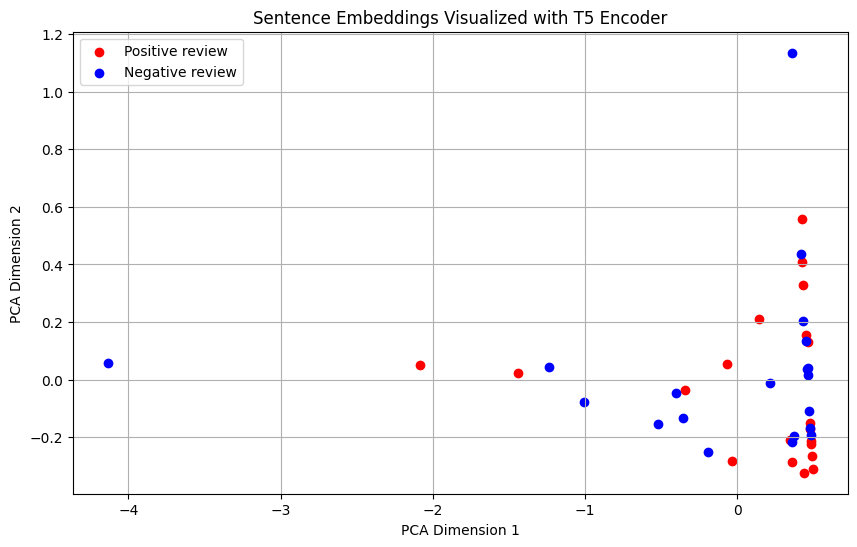

In [ ]:
from torch.nn.utils.rnn import pad_sequence
torch.cuda.empty_cache()

total_sentences = positive_reviews + negative_reviews
sentiment_labels = ["1"] * N_REVIEWS + ["0"] * N_REVIEWS # 1 stands for positive, 0 for negative

#get the text embeddings of the sentences
#use batches in order to be able to run on GPU
text_embeddings = []
n = 2  # batch size

for i in range(0, len(total_sentences), n):
    batch = total_sentences[i:i + n]
    sentence_embeddings = get_text_embeddings(batch, tokenizer, model)
    text_embeddings.extend(sentence_embeddings)

#Pad the sequence of tensors
padded_text_embeddings = pad_sequence(text_embeddings, batch_first=True)  #dimension (batch_size, max_seq_len, embed_dim)

print(f"Text embeddings shape = {padded_text_embeddings.shape}")

#average out the sequence length dimension.
avg_total_sentences = torch.mean(padded_text_embeddings, dim=1).cpu().detach().numpy()
print(f"Average text embedding shape = {avg_total_sentences.shape}")

#fit a PCA and transform "text_embeddings_avg" from 512-dim to 2-dim.
pca = PCA(n_components=2, svd_solver='full')
embedding_2d = pca.fit_transform(avg_total_sentences)
print(f"2d version of embedded average text = {avg_total_sentences.shape}")

# visualize every embedding together with its corresponding sentiment label
label_colors = {}
plt.figure(figsize=(10, 6))
for i, label in enumerate(sentiment_labels):
    x, y = embedding_2d[i]
    if label == "1":
        color = "red"
        label_text = "Positive"
    else:
        color = "blue"
        label_text = "Negative"

    if label_text not in label_colors:
      label_colors[label_text] = color
      plt.scatter(x, y, marker='o', color=color, label="Positive review" if label == "1" else "Negative review")
    else:
      plt.scatter(x, y, marker='o', color=color)
    #plt.text(x + 0.01, y + 0.01, label, fontsize=12)
plt.title("Sentence Embeddings Visualized with T5 Encoder")
plt.legend(loc="best")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.grid()
plt.show()

We can see approximate high-level patterns although it is not fully clear from the embedding alone.

In [ ]:
# Prepare data partitions
MAX_TRAIN_SAMPLES = 1000 
MAX_DEV_SAMPLES = 10
MAX_TEST_SAMPLES = 100
SEED = 42

dataset = imdb["train"].shuffle(seed=SEED)
train_dataset = dataset.select(range(MAX_TRAIN_SAMPLES))
dev_dataset = dataset.select(range(MAX_TRAIN_SAMPLES, MAX_TRAIN_SAMPLES + MAX_DEV_SAMPLES))
test_dataset = imdb["test"].shuffle(seed=SEED).select(range(MAX_TEST_SAMPLES))

In [ ]:
#Inspect the dataset partitions
print(f"Train dataset samples = {len(train_dataset)} samples")
print(f"Dev dataset samples = {len(dev_dataset)} samples")
print(f"Test dataset samples = {len(test_dataset)} samples")

Train dataset samples = 1000 samples
Dev dataset samples = 10 samples
Test dataset samples = 100 samples


In [ ]:
#Inspect some samples in train and test sets
VISUALIZE_SAMPLES = 3
print("Train samples:")
for index, train_sample in enumerate(train_dataset):
    print(train_sample["text"])
    print(train_sample["label"])
    if index == VISUALIZE_SAMPLES - 1:
        break
print("\n")

print("Dev samples:")
for index, dev_sample in enumerate(dev_dataset):
    print(dev_sample["text"])
    print(dev_sample["label"])
    if index == VISUALIZE_SAMPLES - 1:
        break
print("\n")

print("Test samples:")
for index, test_sample in enumerate(test_dataset):
    print(test_sample["text"])
    print(test_sample["label"])
    if index == VISUALIZE_SAMPLES - 1:
        break
print("\n")

Train samples:
There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier's plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it's the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...
1
This movie is a great. The plot is very true to the book which is a classic written by Mark Twain. The movie starts of with a scene where Hank sings a song with a bunch of kids called "when you stub your toe on the moon" It 

As you're going to use text embeddings as input for different classifiers calculate them once and store them (avoids recomputation).

In [15]:
def precompute_embeddings_and_labels(dataset, tokenizer, model):
    embeddings = []
    labels = []
    for index, sample in tqdm(enumerate(dataset)):
        text_sentence = sample["text"]
        embedding = get_text_embeddings([text_sentence], tokenizer, model).mean(dim=1).squeeze()
        if CUDA:
            embedding = embedding.cpu()
        embeddings.append(embedding)

        label = sample["label"]
        labels.append(label)
    embeddings = np.array(embeddings)
    labels = np.array(labels)
    return embeddings, labels

print("Precomputing train set...")
train_emb, train_labels = precompute_embeddings_and_labels(train_dataset, tokenizer, model)
print("Precomputing dev set...")
dev_emb, dev_labels = precompute_embeddings_and_labels(dev_dataset, tokenizer, model)
print("Precomputing test set...")
test_emb, test_labels = precompute_embeddings_and_labels(test_dataset, tokenizer, model)

Precomputing train set...


1000it [04:19,  3.86it/s]


Precomputing dev set...


10it [00:03,  3.32it/s]


Precomputing test set...


100it [00:17,  5.56it/s]


## Classic ML Classifieres

I trained 3 different Sklearn classifiers:

- 1. **K-Nearest-Neighbours (KNN)** 
- 2. **Multi-Layer-Perceptron (MLP)**
- 3. **Support Vector Machine (SVM)**

In [ ]:
def train_classifier(train_data, pca_components, classifier_name):
    train_emb, train_labels = train_data

    #either apply PCA or not
    if pca_components > 0:
        pca = PCA(n_components=pca_components)
        train_features = pca.fit_transform(train_emb)
    else:
        pca = None
        train_features = train_emb.copy()

    #select classifier based on classifier_name

    #implement KNeighboursClassifier
    if classifier_name == "knn":
        from sklearn.neighbors import KNeighborsClassifier
        classifier = KNeighborsClassifier(n_neighbors=5)

    #implement MLPClassifier
    elif classifier_name == "mlp":
        from sklearn.neural_network import MLPClassifier
        classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

    #implement SVM
    elif classifier_name == "svm":
        from sklearn.svm import SVC
        classifier = SVC(kernel='linear') #we can also experiment with other kernels like 'rbf', 'poly', etc.

    else:
        raise NotImplementedError(f"Error! Classifier {classifier_name} is not implemented!")

    classifier.fit(train_features, train_labels)

    return pca, classifier

#routine to evaluate the classifier
def evaluate(evaluation_data, pca, classifier):
    eval_emb, eval_labels = evaluation_data

    if pca is not None:
        eval_features = pca.transform(eval_emb)
    else:
        eval_features = eval_emb.copy()

    pred_labels = classifier.predict(eval_features)

    accuracy = accuracy_score(eval_labels, pred_labels)
    return pred_labels, accuracy

In [ ]:
#Train knn classiffier without PCA
classifier_name = "knn"
pca_components = 0

#Train model
train_data = (train_emb, train_labels)
pca, classifier = train_classifier(train_data, pca_components=pca_components, classifier_name=classifier_name)

#Evaluate accuracy against test set
test_data = (test_emb, test_labels)
test_pred_labels, test_accuracy = evaluate(test_data, pca, classifier)
print(f"Test set accuracy with {classifier_name} and {pca_components} PCA components = {(test_accuracy * 100.0):.2f}%")

Test set accuracy with knn and 0 PCA components = 71.00%


In [ ]:
#Train mlp classiffier without PCA
classifier_name = "mlp"
pca_components = 0

#Train models
train_data = (train_emb, train_labels)
pca, classifier = train_classifier(train_data, pca_components=pca_components, classifier_name=classifier_name)

#Evaluate accuracy against test set
test_data = (test_emb, test_labels)
test_pred_labels, test_accuracy = evaluate(test_data, pca, classifier)
print(f"Test set accuracy with {classifier_name} and {pca_components} PCA components = {(test_accuracy * 100.0):.2f}%")

Test set accuracy with mlp and 0 PCA components = 87.00%


In [ ]:
#Train svm classiffier without PCA
classifier_name = "svm"
pca_components = 0

#Train models
train_data = (train_emb, train_labels)
pca, classifier = train_classifier(train_data, pca_components=pca_components, classifier_name=classifier_name)

#Evaluate accuracy against test set
test_data = (test_emb, test_labels)
test_pred_labels, test_accuracy = evaluate(test_data, pca, classifier)
print(f"Test set accuracy with {classifier_name} and {pca_components} PCA components = {(test_accuracy * 100.0):.2f}%")

Test set accuracy with svm and 0 PCA components = 84.00%


### Results
Without dimensionality reduction MLP performs best with an accuracy of 87%, followed by SVM with 84% and KNN with 71%.

These results suggest, that the data is most likely not linearly seperable since MLP outperform linear SVMs and KNN.

The low performance of KNN also suggests that the data is not really structured in single clusters but it might be more beficial to use hyperlanes (SVM) or non linear methods (MLP)

## Influence of PCA embedding

Visualize how the number of used PCA components effects the performance of our classifiers

In [ ]:
#Measure accuracy as a function of PCA components
#plot accuracy over pca components for the models
knn_performance = []
mlp_performance = []
svm_performance = []
powers_2 = [2**(i+1) for i in range(9)]
print(powers_2)
for pca_components in powers_2:
  train_data = (train_emb, train_labels)
  test_data = (test_emb, test_labels)
  for classifier_name in ["knn", "mlp", "svm"]:
    # Train models
    pca, classifier = train_classifier(train_data, pca_components=pca_components, classifier_name=classifier_name)
    test_pred_labels, test_accuracy = evaluate(test_data, pca, classifier)
    if classifier_name == "knn":
      knn_performance.append(test_accuracy)
    elif classifier_name == "mlp":
      mlp_performance.append(test_accuracy)
    elif classifier_name == "svm":
      svm_performance.append(test_accuracy)
    print(pca_components, f"Test set accuracy with {classifier_name} and {pca_components} PCA components = {(test_accuracy * 100.0):.2f}%")

[2, 4, 8, 16, 32, 64, 128, 256, 512]
2 Test set accuracy with knn and 2 PCA components = 55.00%
2 Test set accuracy with mlp and 2 PCA components = 52.00%
2 Test set accuracy with svm and 2 PCA components = 49.00%
4 Test set accuracy with knn and 4 PCA components = 56.00%
4 Test set accuracy with mlp and 4 PCA components = 58.00%
4 Test set accuracy with svm and 4 PCA components = 65.00%
8 Test set accuracy with knn and 8 PCA components = 68.00%
8 Test set accuracy with mlp and 8 PCA components = 69.00%
8 Test set accuracy with svm and 8 PCA components = 72.00%
16 Test set accuracy with knn and 16 PCA components = 73.00%


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


16 Test set accuracy with mlp and 16 PCA components = 73.00%
16 Test set accuracy with svm and 16 PCA components = 80.00%
32 Test set accuracy with knn and 32 PCA components = 77.00%


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


32 Test set accuracy with mlp and 32 PCA components = 75.00%
32 Test set accuracy with svm and 32 PCA components = 78.00%
64 Test set accuracy with knn and 64 PCA components = 73.00%
64 Test set accuracy with mlp and 64 PCA components = 88.00%
64 Test set accuracy with svm and 64 PCA components = 83.00%
128 Test set accuracy with knn and 128 PCA components = 71.00%
128 Test set accuracy with mlp and 128 PCA components = 86.00%
128 Test set accuracy with svm and 128 PCA components = 84.00%
256 Test set accuracy with knn and 256 PCA components = 70.00%
256 Test set accuracy with mlp and 256 PCA components = 89.00%
256 Test set accuracy with svm and 256 PCA components = 84.00%
512 Test set accuracy with knn and 512 PCA components = 71.00%
512 Test set accuracy with mlp and 512 PCA components = 78.00%
512 Test set accuracy with svm and 512 PCA components = 84.00%


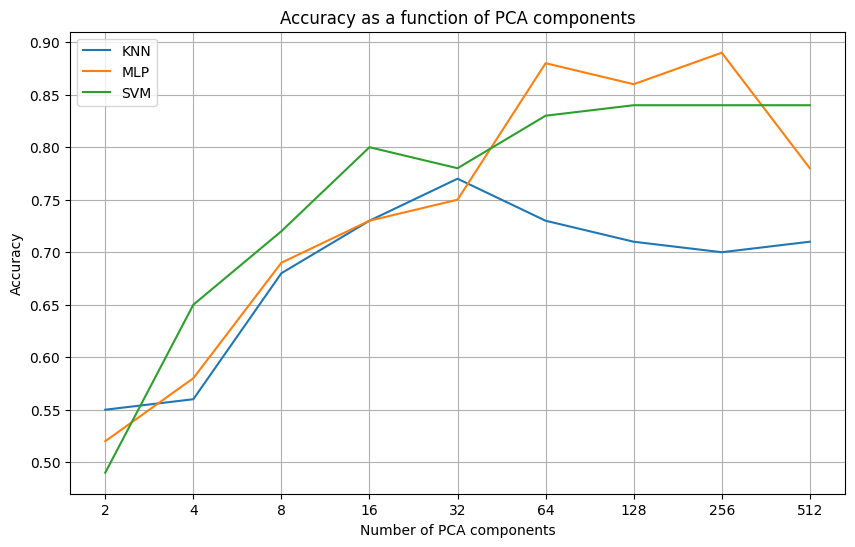

In [ ]:
#Plot PCA components vs accuracies 
plt.figure(figsize=(10,6))
plt.plot(range(9), knn_performance, label="KNN")
plt.plot(range(9), mlp_performance, label="MLP")
plt.plot(range(9), svm_performance, label="SVM")
plt.xticks(range(9), powers_2)
plt.grid()
plt.xlabel("Number of PCA components")
plt.ylabel("Accuracy")
plt.title("Accuracy as a function of PCA components")
plt.legend(loc="best")
plt.show()

### Results

The plot illustrates that all models experience an increase in accuracy as the number of dimensions rises up to 32.
The SVM model shows a steady improvement, while the KNN model reaches its highest accuracy at 32 components. In contrast, the MLP model performs best with 128 dimensions.

Beyond 32 dimensions, KNN’s performance begins to decline, and MLP’s accuracy also drops after 128 dimensions.
These trends suggest that both models are overfitting.
Additionally, while SVM continues to improve beyond 32 dimensions, the increase in accuracy is marginal, indicating that additional dimensions provide minimal benefit to the model’s training.

Despite this, the consistent performance of SVM highlights its robustness compared to the other two models.

Overall, the best results appear to be achieved with an MLP using 128 dimensions. However, to confirm this, cross-validation on a larger subset of the data would be desirable.

Another key observation is that KNN is consistently outperformed by both SVM and MLP, suggesting it may not be suitable for further consideration in this context.


## Classification using T5 pretrained model

I also experimented using the full T5 encoder-decoder model for sentiment classification. By prepending the prompt **"sst2 sentence:"** to each input the model can directly output "Positive" or "Negative" for a given sample. I implemented a loop to process the test set in this way and compared the results to those from the classic ML classifiers.

In [ ]:
ground_truth_labels = []
t5_pred_labels = []
task_prefix = "sst2 sentence:"

for index, sample in tqdm(enumerate(test_dataset)):

    #extract actual texts and labels from the sample
    text_sentence, ground_truth_label = sample["text"], sample["label"]
    #consturct text with task prefix
    text_sentence = f"{task_prefix} {text_sentence}"
    #genrate ids from text
    input_ids = tokenizer(text_sentence, return_tensors="pt").input_ids
    if CUDA:
        input_ids = input_ids.cuda()
    with torch.no_grad():
        output_ids = model.generate(input_ids)
    #predict the sentiment
    sentiment = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    if sentiment == "positive":
        t5_pred_label = 1
    elif sentiment == "negative":
        t5_pred_label = 0
    #append to lists
    ground_truth_labels.append(ground_truth_label)
    t5_pred_labels.append(t5_pred_label)

accuracy = accuracy_score(ground_truth_labels, t5_pred_labels)
print(f"Pretrained T5 accuracy = {(accuracy * 100.0):.2f}%")

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100it [00:26,  3.77it/s]

Pretrained T5 accuracy = 87.00%


### Results

The pretrained T5 encoder-decoder achieves an overall accuracy of 87% on the test dataset, which is surprisingly comparable to the performance of the MLP, which also reaches 87% (without dimensionality reduction).
These results suggest that MLPs might be just as effective for sentiment prediction as pretrained models like T5.

However, to confirm this, both the T5 encoder-decoder and the MLP would need to be fine-tuned and evaluated for accuracy on a larger dataset, with cross-validation used for the MLP.

These findings may also indicate that sentiment prediction is a relatively straightforward task that does not necessarily require complex architectures like the T5 encoder-decoder.
Further testing is needed to verify this hypothesis.

Additionally, it would be valuable to evaluate the performance of SVMs and MLPs on larger or more diverse datasets to determine whether they can maintain their competitiveness with the T5 encoder-decoder.
Choosing a dataset with more subtle or context-dependent sentiments might also better highlight the strengths of the T5 encoder-decoder.


## Finetuned T5 classifier

T5 is not specifically trained on IMDB reviews, so its natural to fine-tune the model on the IMDB training set and evaluate its performance afterwards. I experimented with different fine-tuning hyperparameters and observed the results of how these choices affected the model's accuracy.


In [ ]:
#Function to preprocess data: create input prompt and target label
def preprocess_data(example):
    #Prefix the review text with "sst2 sentence:" to format it as a sentiment classification task
    example['input_text'] = "sst2 sentence: " + example['text']
    example['target_text'] = "positive" if example['label'] == 1 else "negative"
    return example

#Apply preprocessing to train and test splits
dataset = imdb.map(preprocess_data)
train_data = dataset['train']
test_data = dataset['test']

#Tokenize the data
def tokenize_data(example):
    #Tokenize inputs and targets
    inputs = tokenizer(example['input_text'], padding='max_length', truncation=True, max_length=128)
    targets = tokenizer(example['target_text'], padding='max_length', truncation=True, max_length=5)
    #Rename columns for Trainer compatibility
    inputs['labels'] = targets['input_ids']
    return inputs

#Apply tokenization to the dataset
train_data = train_data.map(tokenize_data, batched=True)
test_data = test_data.map(tokenize_data, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [27]:
#for learning rate e-4: 86%
#for learning rate e-5: slow convergence 88%
#for learning rate e-6: even slower convergence 87%
LEARNING_RATE = 1e-5
BATCH_SIZE = 8 #stay at smaller batch size because of hardware capabilities
#choose MAX_STEPS=150 as loss reduces in realtiv smaller steps then before
MAX_STEPS = 150 # number of steps to train the model, reduce if training takes too long (for CPU especially)
WEIGHT_DECAY = 0.01 #generally between 0.01 and 0.1
LOGGING_STEPS = 20

In [ ]:
#Remove unnecessary columns
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

#Training arguments
training_args = TrainingArguments(
    output_dir="./t5_imdb",
    evaluation_strategy="no",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    max_steps=MAX_STEPS,
    weight_decay=WEIGHT_DECAY,
    logging_dir='./logs',
    logging_steps=LOGGING_STEPS,
    save_strategy="steps",
    save_steps=MAX_STEPS // 5,
    report_to="none",
    do_eval=False
)

# Reinstantiate pretrained model
tokenizer = T5Tokenizer.from_pretrained(T5_MODEL)
model = T5ForConditionalGeneration.from_pretrained(T5_MODEL)

if CUDA:
    model = model.cuda()

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [ ]:
#Fine-tune the model
trainer.train()

#Save the model
model.save_pretrained("t5_imdb_finetuned")
tokenizer.save_pretrained("t5_imdb_finetuned")

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
20,15.898700
40,12.507500
60,9.681600
80,7.936700
100,6.460600
120,5.239800
140,4.826800


('t5_imdb_finetuned/tokenizer_config.json',
 't5_imdb_finetuned/special_tokens_map.json',
 't5_imdb_finetuned/spiece.model',
 't5_imdb_finetuned/added_tokens.json')

In [ ]:
#Load fine-tuned model
model_path = "t5_imdb_finetuned"
tokenizer_ft = T5Tokenizer.from_pretrained(model_path)
model_ft = T5ForConditionalGeneration.from_pretrained(model_path)
if CUDA:
    model_ft = model_ft.cuda()

In [ ]:
#Reimplement the inference loop for the fine-tuned model
ground_truth_labels = []
t5_pred_labels = []
for index, sample in tqdm(enumerate(test_dataset)):
    text_sentence = sample["text"]
    text_sentence = f"sst2 sentence: {text_sentence}"
    ground_truth_label = sample["label"]

    input_ids = tokenizer_ft(text_sentence, return_tensors="pt").input_ids
    if CUDA:
        input_ids = input_ids.cuda()
    with torch.no_grad():
        output_ids = model_ft.generate(input_ids)
    sentiment = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    if sentiment == "positive":
        t5_pred_label = 1
    elif sentiment == "negative":
        t5_pred_label = 0
    else:
        print(f"Model predicted different! = {sentiment}")
        if ground_truth_label == 0:
            t5_pred_label = 1
        else:
            t5_pred_label = 0

    ground_truth_labels.append(ground_truth_label)
    t5_pred_labels.append(t5_pred_label)

accuracy = accuracy_score(ground_truth_labels, t5_pred_labels)
print(f"Pretrained T5 accuracy = {(accuracy * 100.0):.2f}%")

0it [00:00, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
16it [00:04,  2.54it/s]

Model predicted different! = a gruesome scene.br />br /


90it [00:24,  1.81it/s]

Model predicted different! = 'hamlet' ending... again... where is the sequel!!!'


100it [00:27,  3.69it/s]

Pretrained T5 accuracy = 88.00%


In [ ]:
#Do a simple gridsearch to find best hyperparameters (learning rate and weight decay)
highest_acc=0

#iterate over learning rates
for i in range(1,4):
  LEARNING_RATE = (i**2)*1e-4
  for j in range(1,4):
    WEIGHT_DECAY = (j**2)*1e-2

    #Code copied from above

    #Remove unnecessary columns
    train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    #Training arguments
    training_args = TrainingArguments(
        output_dir="./t5_imdb",
        evaluation_strategy="no",
        learning_rate=LEARNING_RATE,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        max_steps=MAX_STEPS,
        weight_decay=WEIGHT_DECAY,
        logging_dir='./logs',
        logging_steps=LOGGING_STEPS,
        save_strategy="steps",
        save_steps=MAX_STEPS // 5,
        report_to="none",
        do_eval=False
    )

    #Reinstantiate pretrained model
    tokenizer = T5Tokenizer.from_pretrained(T5_MODEL)
    model = T5ForConditionalGeneration.from_pretrained(T5_MODEL)

    if CUDA:
        model = model.cuda()

    #Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=test_data
    )

    #Fine-tune the model
    trainer.train()

    #Save the model
    model.save_pretrained("t5_imdb_finetuned")
    tokenizer.save_pretrained("t5_imdb_finetuned")

    #Reimplement here the test evaluation loop from before, to get the accuracy for this checkpoint.
    ground_truth_labels = []
    t5_pred_labels = []
    for index, sample in tqdm(enumerate(test_dataset)):
        text_sentence = sample["text"]
        text_sentence = f"sst2 sentence: {text_sentence}"
        ground_truth_label = sample["label"]

        input_ids = tokenizer_ft(text_sentence, return_tensors="pt").input_ids
        if CUDA:
            input_ids = input_ids.cuda()
        with torch.no_grad():
            output_ids = model_ft.generate(input_ids)
        sentiment = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        if sentiment == "positive":
            t5_pred_label = 1
        elif sentiment == "negative":
            t5_pred_label = 0
        else:
            print(f"Model predicted different! = {sentiment}")
            if ground_truth_label == 0:
                t5_pred_label = 1
            else:
                t5_pred_label = 0

        ground_truth_labels.append(ground_truth_label)
        t5_pred_labels.append(t5_pred_label)

    accuracy = accuracy_score(ground_truth_labels, t5_pred_labels)

    #check wheter these params are best yet seen
    if accuracy>highest_acc:
      highest_acc=accuracy
      best_params=(LEARNING_RATE, WEIGHT_DECAY)

    print(f"Pretrained T5 accuracy = {(accuracy * 100.0):.2f}%")

print(f"Best learning rate= {best_params[0]}")
print(f"Best weight decay= {best_params[1]}")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
20,6.067800
40,0.683100
60,0.186600
80,0.144300
100,0.120400
120,0.106400
140,0.101200


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100it [00:26,  3.81it/s]
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Pretrained T5 accuracy = 86.00%


max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
20,6.043300
40,0.648100
60,0.186100
80,0.145900
100,0.123200
120,0.104700
140,0.099800


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100it [00:27,  3.70it/s]
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Pretrained T5 accuracy = 86.00%


max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
20,6.032300
40,0.657700
60,0.188100
80,0.148100
100,0.121100
120,0.107700
140,0.099600


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100it [00:26,  3.77it/s]
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Pretrained T5 accuracy = 87.00%


max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
20,2.332200
40,0.145400
60,0.102700
80,0.103800
100,0.109200
120,0.088300
140,0.089600


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100it [00:26,  3.80it/s]
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Pretrained T5 accuracy = 90.00%


max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
20,2.337400
40,0.157600
60,0.111100
80,0.102500
100,0.106800
120,0.090100
140,0.092800


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100it [00:26,  3.73it/s]
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Pretrained T5 accuracy = 87.00%


max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
20,2.359500
40,0.144200
60,0.103800
80,0.104000
100,0.110400
120,0.086900
140,0.087300


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100it [00:26,  3.74it/s]
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Pretrained T5 accuracy = 88.00%


max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
20,1.700300
40,0.117600
60,0.120700
80,0.114800
100,0.111400
120,0.094600
140,0.089100


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100it [00:26,  3.77it/s]
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Pretrained T5 accuracy = 84.00%


max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
20,1.729700
40,0.120100
60,0.121200
80,0.117500
100,0.108900
120,0.087200
140,0.086200


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100it [00:26,  3.76it/s]
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Pretrained T5 accuracy = 87.00%


max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
20,1.709900
40,0.140400
60,0.124200
80,0.113100
100,0.111400
120,0.096800
140,0.094800


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100it [00:26,  3.81it/s]

Pretrained T5 accuracy = 87.00%
Best learning rate= 0.0004
Best weight decay= 0.01


### Results

With the given hyperparameters the pretrained T5 model has an accuracy of 89%.

I ran a gridsearch to find the best hyperparameters for the learning rate and the weight decline.
To do so I started by doing experiments with the learning rate (e-4, e-5 and e-6) to get an idea which values are most applicable. For more details look into the comments where the hyperparameters are defined.

The results of the grid search reveal that the best combination of parameters is: Learning rate= 4e-4 and Weight decay = 0.01 with an accuracy of 90%
The learning rate of 4e-4 appears to strike an optimal balance between fast convergence and stability, preventing overfitting that might occur at higher rates.

This improvement in accuracy (from 89% to 90%) may indicate that the initial choice of hyperparameters was close but not fully optimized.
By fine-tuning these parameters, we managed to enhance the model’s ability to learn effectively from the training data while avoiding overfitting.
Further analysis and experimentation with additional values or combinations might be desirable to get more details on the optimal configuration for this task.


In [34]:
print(highest_acc)

0.9
